# Teeth classification

## preprocessing 

#### lib 

In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers, models, applications, optimizers, callbacks, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image



#### Set Seed for Reproducibility

In [2]:
tf.random.set_seed(42)
np.random.seed(42)

#### Dataset Paths

In [3]:
train_dir = "C:\\Users\\Test\\Downloads\\Teeth DataSet\\Teeth_Dataset\\Training"
val_dir = "C:\\Users\\Test\\Downloads\\Teeth DataSet\\Teeth_Dataset\\Validation"
test_dir = "C:\\Users\\Test\\Downloads\\Teeth DataSet\\Teeth_Dataset\\Testing"


#### Image Size & Batch Size

In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30

#### Data Augmentation

In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255.0, # normalization
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
)

####  No Augmentation for Validation & Test Set

In [6]:
val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0)

#### Load Data

In [7]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical")
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical")
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical", shuffle=False)

Found 3150 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


#### Class Distribution Visualization

C:\Users\Test\AppData\Local\Temp\ipykernel_11952\2454869461.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette="viridis")


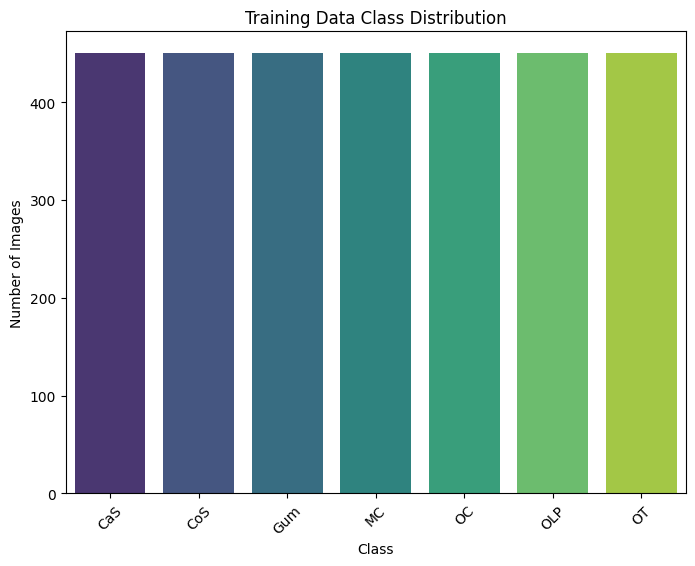

In [8]:
def plot_class_distribution(generator, title):
    labels = list(generator.class_indices.keys())
    counts = np.bincount(generator.classes)
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x=labels, y=counts, palette="viridis")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(train_generator, "Training Data Class Distribution")


#### Visualize Augmented vs. Original Image

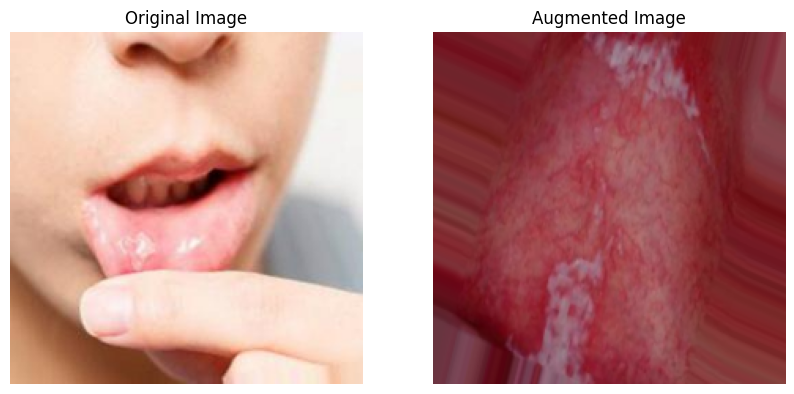

In [9]:
def visualize_augmentation(generator):
    images, labels = next(generator)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Original Image
    img_original = Image.open(generator.filepaths[0]).resize(IMG_SIZE)
    axes[0].imshow(img_original)
    axes[0].set_title("Original Image")
    axes[0].axis("off")
    
    # Augmented Image
    axes[1].imshow(images[0])
    axes[1].set_title("Augmented Image")
    axes[1].axis("off")
    
    plt.show()

visualize_augmentation(train_generator)

####  Compute Class Weights for Balancing

In [10]:
labels = list(train_generator.class_indices.keys())
num_classes = len(labels)
class_counts = np.bincount(train_generator.classes)
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

## Model

### Train CNN Model from Scratch

In [17]:
def build_cnn_model(input_shape, num_classes):
    model = models.Sequential([
        # Conv Block 1
        layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # Conv Block 2
        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # Conv Block 3
        layers.Conv2D(128, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),

        # Conv Block 4
        layers.Conv2D(256, (3, 3), activation="relu", padding="same"),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),

        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation="softmax"),
    ])
    return model

#### Build & Train CNN Model

In [18]:
cnn_model = build_cnn_model((224, 224, 3), num_classes)
cnn_model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])


##### Learning Rate Scheduler & Early Stopping

In [19]:
lr_scheduler = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-7)
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=7, restore_best_weights=True)


#### Train CNN Model

In [21]:
cnn_history = cnn_model.fit(train_generator, validation_data=val_generator, epochs=20, class_weight=class_weights, callbacks=[lr_scheduler, early_stopping])

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.5719 - loss: 1.1602 - val_accuracy: 0.5292 - val_loss: 1.2852 - learning_rate: 5.0000e-04
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.5845 - loss: 1.1302 - val_accuracy: 0.5340 - val_loss: 1.2356 - learning_rate: 5.0000e-04
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.5910 - loss: 1.1011 - val_accuracy: 0.6839 - val_loss: 0.8468 - learning_rate: 5.0000e-04
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 179s 2s/step - accuracy: 0.6273 - loss: 0.9929 - val_accuracy: 0.6527 - val_loss: 0.9311 - learning_rate: 5.0000e-04
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 181s 2s/step - accuracy: 0.6559 - loss: 0.9723 - val_accuracy: 0.5730 - val_loss: 1.2307 - learning_rate: 5.0000e-04
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6557 - loss: 0.9157
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
99/99 ━━━━━━━━━━━━━━━━━━━━ 180s 2s/step - accuracy: 0.6556 - loss:

#### Evaluate CNN Model

In [22]:
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(test_generator)
print(f"✅ CNN Test Accuracy: {cnn_test_accuracy:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 285ms/step - accuracy: 0.9562 - loss: 0.1669
✅ CNN Test Accuracy: 0.9290


33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 345ms/step


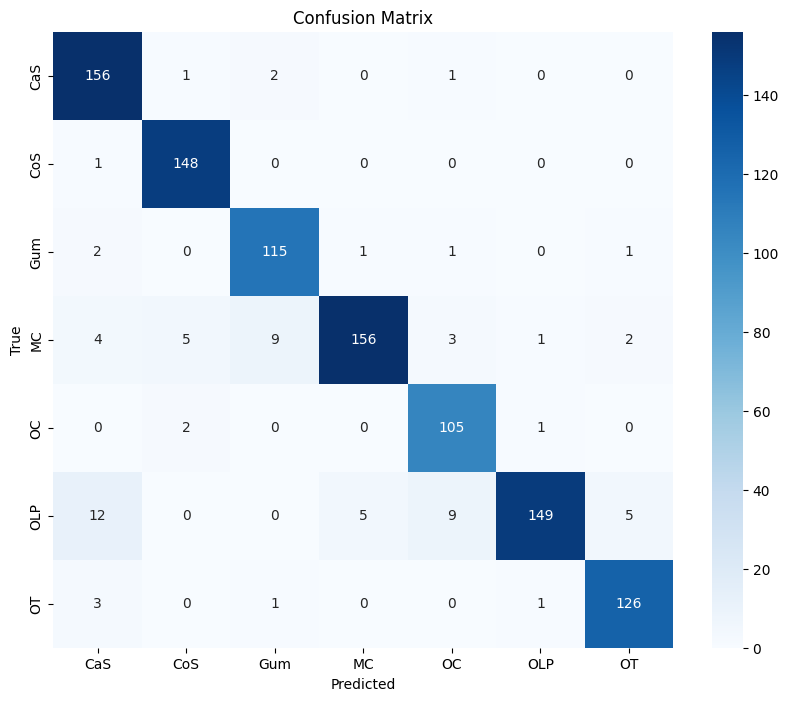

In [39]:
y_pred = cnn_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1) 

# Step 2: Get the true labels
y_true = test_generator.classes

# Step 3: Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Step 4: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

#### fine Tune CNN Model

In [42]:
# Reduce Learning Rate for Fine-Tuning
cnn_model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),  # Lower LR
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

#  Fine-Tune CNN for a Few More Epochs
fine_tune_cnn_history = cnn_model.fit(train_generator,
                                      validation_data=val_generator,
                                      epochs=10,  # Reduce epochs to prevent overfitting
                                      class_weight=class_weights,
                                      callbacks=[lr_scheduler, early_stopping])

#  Evaluate Fine-Tuned CNN Model
fine_tune_cnn_test_loss, fine_tune_cnn_test_accuracy = cnn_model.evaluate(test_generator)
print(f"✅ Fine-Tuned CNN Test Accuracy: {fine_tune_cnn_test_accuracy:.4f}")


Epoch 1/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 205s 2s/step - accuracy: 0.8470 - loss: 0.4362 - val_accuracy: 0.9358 - val_loss: 0.2314 - learning_rate: 1.0000e-05
Epoch 2/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.8592 - loss: 0.4250 - val_accuracy: 0.9377 - val_loss: 0.2228 - learning_rate: 1.0000e-05
Epoch 3/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.8621 - loss: 0.4181 - val_accuracy: 0.9280 - val_loss: 0.2493 - learning_rate: 1.0000e-05
Epoch 4/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 192s 2s/step - accuracy: 0.8603 - loss: 0.4420 - val_accuracy: 0.9309 - val_loss: 0.2332 - learning_rate: 1.0000e-05
Epoch 5/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8652 - loss: 0.4069
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
99/99 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.8652 - loss: 0.4069 - val_accuracy: 0.9309 - val_loss: 0.2312 - learning_rate: 1.0000e-05
Epoch 6/10
99/99 ━━━━━━━━━━━━━━━━━━━━ 189s 2s/step - accuracy: 0.8691 - loss:

33/33 ━━━━━━━━━━━━━━━━━━━━ 11s 307ms/step


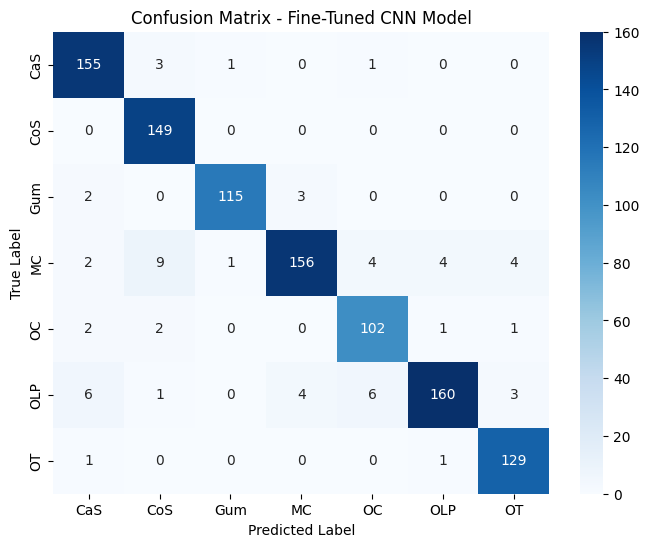

Classification Report:
               precision    recall  f1-score   support

         CaS       0.92      0.97      0.95       160
         CoS       0.91      1.00      0.95       149
         Gum       0.98      0.96      0.97       120
          MC       0.96      0.87      0.91       180
          OC       0.90      0.94      0.92       108
         OLP       0.96      0.89      0.92       180
          OT       0.94      0.98      0.96       131

    accuracy                           0.94      1028
   macro avg       0.94      0.94      0.94      1028
weighted avg       0.94      0.94      0.94      1028



In [43]:
y_true = test_generator.classes  # True labels
y_pred = cnn_model.predict(test_generator)  # Predictions
y_pred = np.argmax(y_pred, axis=1)  # Convert one-hot to class indices

# 📌 Step 2: Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# 📌 Step 3: Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Fine-Tuned CNN Model")
plt.show()

# 📌 Step 4: Print Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))

#### Save CNN Model

In [27]:
cnn_model.save("cnn_teeth_classifier.h5")

In [44]:
cnn_model.save("fine_tuned_cnn_teeth_classifier.h5")

### Apply Transfer Learning with MobileNetV2

In [23]:
base_model = applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # ✅ Freeze all layers initially

#### Build Transfer Learning Model

In [25]:
def build_transfer_model(base_model, num_classes):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1024, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    return model

#### Compile & Train Transfer Learning Model

In [26]:
transfer_model = build_transfer_model(base_model, num_classes)
transfer_model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

#### Train Model (Feature Extraction Phase)

In [28]:
transfer_history = transfer_model.fit(train_generator, validation_data=val_generator, epochs=15, class_weight=class_weights, callbacks=[lr_scheduler, early_stopping])

Epoch 1/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 95s 892ms/step - accuracy: 0.3191 - loss: 3.1709 - val_accuracy: 0.6021 - val_loss: 2.2364 - learning_rate: 1.0000e-04
Epoch 2/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 86s 865ms/step - accuracy: 0.5610 - loss: 2.3729 - val_accuracy: 0.7354 - val_loss: 1.9297 - learning_rate: 1.0000e-04
Epoch 3/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 86s 865ms/step - accuracy: 0.6184 - loss: 2.1733 - val_accuracy: 0.7928 - val_loss: 1.7510 - learning_rate: 1.0000e-04
Epoch 4/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 85s 862ms/step - accuracy: 0.6598 - loss: 2.0687 - val_accuracy: 0.8142 - val_loss: 1.6427 - learning_rate: 1.0000e-04
Epoch 5/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 85s 861ms/step - accuracy: 0.6953 - loss: 1.9475 - val_accuracy: 0.8366 - val_loss: 1.5646 - learning_rate: 1.0000e-04
Epoch 6/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 85s 862ms/step - accuracy: 0.7378 - loss: 1.8621 - val_accuracy: 0.8560 - val_loss: 1.5048 - learning_rate: 1.0000e-04
Epoch 7/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 87s 876ms/step - acc

#### Evaluate Transfer Learning Model

In [29]:
transfer_test_loss, transfer_test_accuracy = transfer_model.evaluate(test_generator)
print(f"✅ Transfer Learning Test Accuracy (Before Fine-Tuning): {transfer_test_accuracy:.4f}")

33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 409ms/step - accuracy: 0.9716 - loss: 1.1395
✅ Transfer Learning Test Accuracy (Before Fine-Tuning): 0.9484


#### Unfreeze Model for Fine-Tuning

In [30]:
base_model.trainable = True
transfer_model.compile(optimizer=optimizers.Adam(learning_rate=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])

#### Fine-Tune Model

In [31]:
fine_tune_history = transfer_model.fit(train_generator, validation_data=val_generator, epochs=20, class_weight=class_weights, callbacks=[lr_scheduler, early_stopping])

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 268s 2s/step - accuracy: 0.4103 - loss: 2.8164 - val_accuracy: 0.8551 - val_loss: 1.4264 - learning_rate: 1.0000e-05
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.5269 - loss: 2.4000 - val_accuracy: 0.7850 - val_loss: 1.6508 - learning_rate: 1.0000e-05
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.5838 - loss: 2.1979 - val_accuracy: 0.7228 - val_loss: 1.8436 - learning_rate: 1.0000e-05
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6378 - loss: 2.0525
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
99/99 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.6378 - loss: 2.0526 - val_accuracy: 0.7169 - val_loss: 1.8873 - learning_rate: 1.0000e-05
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 228s 2s/step - accuracy: 0.6428 - loss: 2.0394 - val_accuracy: 0.7218 - val_loss: 1.8488 - learning_rate: 5.0000e-06
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.6552 - loss:

#### Evaluate Fine-Tuned Model

In [32]:
fine_tune_test_loss, fine_tune_test_accuracy = transfer_model.evaluate(test_generator)
print(f"✅ Fine-Tuned Transfer Learning Test Accuracy: {fine_tune_test_accuracy:.4f}")


33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 386ms/step - accuracy: 0.9250 - loss: 1.2229
✅ Fine-Tuned Transfer Learning Test Accuracy: 0.8609


#### Save Best Transfer Learning Model

In [33]:
transfer_model.save("best_teeth_classifier.h5")

## Visualization & Model Comparison

In [34]:
def plot_training(histories, labels):
    plt.figure(figsize=(12, 5))
    for history, label in zip(histories, labels):
        plt.plot(history.history["accuracy"], label=f"{label} Train Accuracy")
        plt.plot(history.history["val_accuracy"], label=f"{label} Val Accuracy")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.show()

#### Compare CNN, Transfer Learning, and Fine-Tuned Model

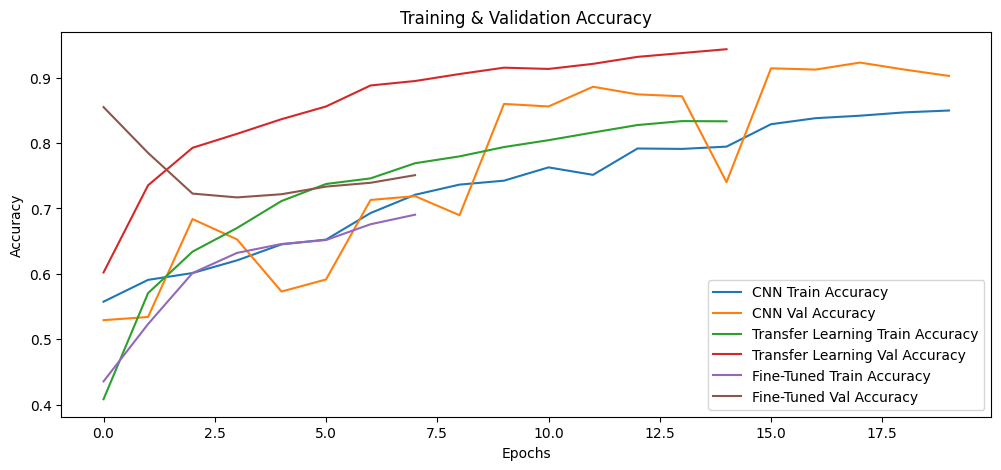

In [35]:
plot_training([cnn_history, transfer_history, fine_tune_history], ["CNN", "Transfer Learning", "Fine-Tuned"])

#### Confusion Matrix & Classification Report

In [36]:
y_true = test_generator.classes
y_pred = transfer_model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))

33/33 ━━━━━━━━━━━━━━━━━━━━ 16s 429ms/step
Confusion Matrix:
[[157   1   0   0   2   0   0]
 [  2 147   0   0   0   0   0]
 [ 10   4 104   0   0   0   2]
 [ 10  16   2 141   9   0   2]
 [  2   1   0   0 105   0   0]
 [ 24   2   0  11  20 115   8]
 [  8   1   1   1   3   1 116]]

Classification Report:
              precision    recall  f1-score   support

         CaS       0.74      0.98      0.84       160
         CoS       0.85      0.99      0.92       149
         Gum       0.97      0.87      0.92       120
          MC       0.92      0.78      0.85       180
          OC       0.76      0.97      0.85       108
         OLP       0.99      0.64      0.78       180
          OT       0.91      0.89      0.90       131

    accuracy                           0.86      1028
   macro avg       0.88      0.87      0.86      1028
weighted avg       0.88      0.86      0.86      1028



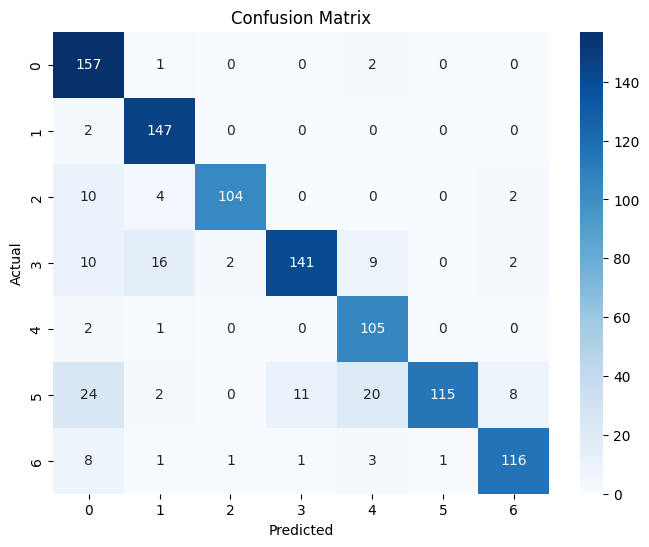

In [38]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# r

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, callbacks, regularizers
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 📌 Set Seed for Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# 📌 Dataset Paths
train_dir = "C:\\Users\\Test\\Downloads\\Teeth DataSet\\Teeth_Dataset\\Training"
val_dir = "C:\\Users\\Test\\Downloads\\Teeth DataSet\\Teeth_Dataset\\Validation"
test_dir = "C:\\Users\\Test\\Downloads\\Teeth DataSet\\Teeth_Dataset\\Testing"

# 📌 Image Size & Batch Size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 50

# 📌 Data Augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest",
)

# 📌 No Augmentation for Validation & Test Set
val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0 / 255.0)

# 📌 Load Data
train_generator = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical")
val_generator = val_test_datagen.flow_from_directory(val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical")
test_generator = val_test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical", shuffle=False)

# 📌 Compute Class Weights for Balancing
labels = list(train_generator.class_indices.keys())
num_classes = len(labels)
class_counts = np.bincount(train_generator.classes)
class_weights = compute_class_weight('balanced', classes=np.unique(train_generator.classes), y=train_generator.classes)
class_weights = dict(enumerate(class_weights))

# 📌 Load Pretrained MobileNetV2
base_model = applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # ✅ Freeze all layers initially

# 📌 Build Model
def build_model(base_model, num_classes):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(1024, activation="relu", kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    return model

model = build_model(base_model, num_classes)

# 📌 Compile Model
initial_learning_rate = 0.0001
optimizer = optimizers.Adam(learning_rate=initial_learning_rate)

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# 📌 Learning Rate Scheduler
lr_scheduler = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, verbose=1, min_lr=1e-7)

# 📌 Early Stopping
early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

# 📌 Train Model (Feature Extraction Phase)
history = model.fit(train_generator, validation_data=val_generator, epochs=15, class_weight=class_weights, callbacks=[lr_scheduler, early_stopping])

# 📌 Fine-Tune Model (Unfreeze Some Layers)
base_model.trainable = True

# 📌 Compile Again for Fine-Tuning
model.compile(optimizer=optimizers.Adam(learning_rate=0.00001), loss="categorical_crossentropy", metrics=["accuracy"])

# 📌 Fine-Tune Model (Phase 2)
fine_tune_history = model.fit(train_generator, validation_data=val_generator, epochs=20, class_weight=class_weights, callbacks=[lr_scheduler, early_stopping])

# 📌 Save Best Model for Deployment
model.save("best_teeth_classifier.h5")  # ✅ Save the trained model

# 📌 Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"✅ Final Test Accuracy: {test_accuracy:.4f}")

# 📌 Plot Training Performance
def plot_training(history, fine_tune_history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy (Phase 1)")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy (Phase 1)")
    plt.plot(fine_tune_history.history["accuracy"], label="Train Accuracy (Phase 2)", linestyle="dashed")
    plt.plot(fine_tune_history.history["val_accuracy"], label="Val Accuracy (Phase 2)", linestyle="dashed")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss (Phase 1)")
    plt.plot(history.history["val_loss"], label="Val Loss (Phase 1)")
    plt.plot(fine_tune_history.history["loss"], label="Train Loss (Phase 2)", linestyle="dashed")
    plt.plot(fine_tune_history.history["val_loss"], label="Val Loss (Phase 2)", linestyle="dashed")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")

    plt.show()

plot_training(history, fine_tune_history)

# 📌 Confusion Matrix & Classification Report
y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred = np.argmax(y_pred, axis=1)

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


Found 3150 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


c:\Users\Test\Downloads\Teeth DataSet\Task1\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.2934 - loss: 3.2379 - val_accuracy: 0.6284 - val_loss: 2.2275 - learning_rate: 1.0000e-04
Epoch 2/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.5393 - loss: 2.4245 - val_accuracy: 0.7189 - val_loss: 1.9317 - learning_rate: 1.0000e-04
Epoch 3/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.6234 - loss: 2.1913 - val_accuracy: 0.7617 - val_loss: 1.7716 - learning_rate: 1.0000e-04
Epoch 4/15
99/99 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.6637 - loss: 2.0434 - val_accuracy: 0.8132 - val_loss: 1.6316 - learning_rate: 1.0000e-04
Epoch 5/15
45/99 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.6657 - loss: 2.0318

KeyboardInterrupt: 